In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
from scipy.stats import poisson, binom, nbinom, lognorm, pareto, gamma
from statsmodels.stats.outliers_influence import variance_inflation_factor
import tensorflow as tf
import tensorflow_probability as tfp
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
import seaborn as sns

In [232]:
# Load the claims data file into a DataFrame 
file_path = "/Users/thomasdeconinck/Documents/GitHub/Assurance-Code-Python/claim_data_group4_2024.csv"
claims_data = pd.read_csv(file_path)

In [233]:
claims_data

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
0,2271893,0,0.83,E,5,17,53,64,B2,Diesel,3317,R93,0.0
1,1111864,0,0.24,E,5,2,27,64,B3,Diesel,2740,R22,0.0
2,72908,0,0.50,E,7,11,67,50,B3,Regular,4762,R93,0.0
3,2283027,0,0.08,B,5,8,28,60,B1,Diesel,64,R91,0.0
4,1123838,0,0.03,A,11,1,38,50,B2,Regular,16,R24,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,70445,0,1.00,C,5,11,37,56,B2,Diesel,317,R82,0.0
99996,4163362,0,0.22,E,6,13,58,50,B1,Diesel,4762,R93,0.0
99997,2081912,0,1.00,E,5,1,49,50,B2,Diesel,4998,R11,0.0
99998,2012998,0,0.71,D,9,9,36,54,B1,Regular,1541,R91,0.0


# Descriptive Statistics

In [20]:
def plot_variable(data, group_var, ax_freq, ax_sev):
    """
    Function to plot frequency and severity of claims by policyholder characteristics.
    
    :param data: DataFrame to plot.
    :param group_var: The variable to group by.
    :param ax_freq: The axes object for frequency plots.
    :param ax_sev: The axes object for severity plots.
    """
    # Calculate frequency and severity
    freq = data.groupby(group_var)['ClaimNb'].sum()
    sev = data[data['ClaimNb'] > 0].groupby(group_var)['ClaimAmount'].mean()
    
    dollar_formatter = FuncFormatter(lambda x, pos: f'${int(x)}')

    # Plot Frequency
    sns.barplot(x=freq.index, y=freq.values, ax=ax_freq)
    ax_freq.set_title(f'Claim Frequency by {group_var}')
    ax_freq.set_xlabel(group_var)
    ax_freq.set_ylabel('Total Claims')
    ax_freq.tick_params(axis='x')
    if group_var in ['BonusMalus','DrivAge', 'VehAge']:
        ax_freq.xaxis.set_major_locator(MaxNLocator(10))

    # Plot Severity
    sns.barplot(x=sev.index, y=sev.values, ax=ax_sev)
    ax_sev.set_title(f'Claim Severity by {group_var}')
    ax_sev.set_xlabel(group_var)
    ax_sev.set_ylabel('Average Claim Amount')
    ax_sev.tick_params(axis='x')
    ax_sev.yaxis.set_major_formatter(dollar_formatter)
    if group_var in ['BonusMalus', 'DrivAge']:
        ax_sev.xaxis.set_major_locator(MaxNLocator(10))

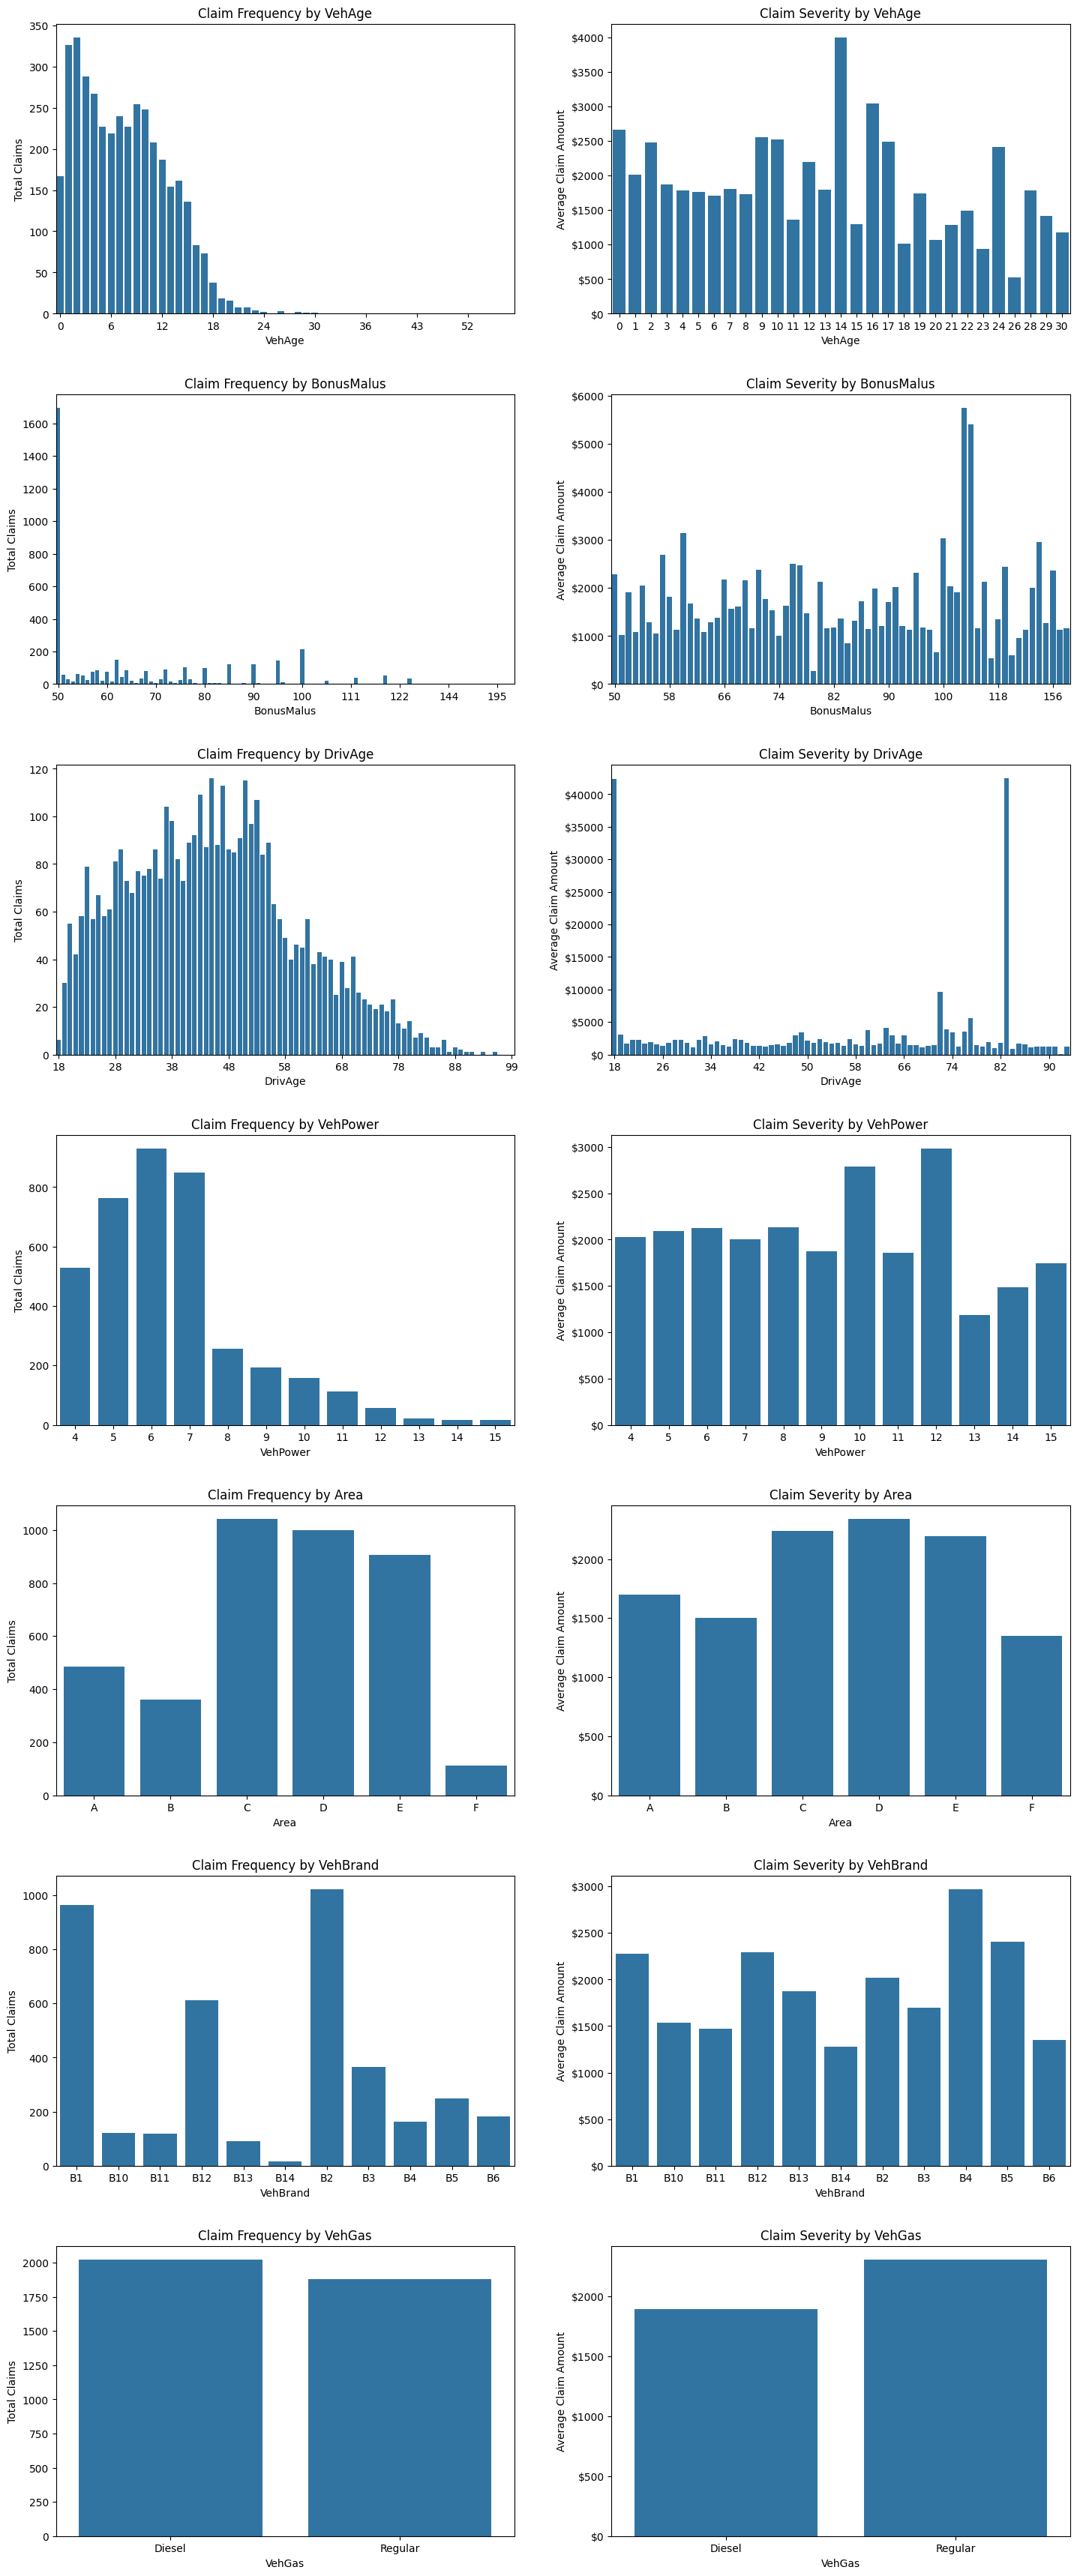

In [21]:
# Variables to plot frequency and severity of claims by policyholder characteristics
variables = ['VehAge', 'BonusMalus', 'DrivAge', 'VehPower', 'Area', 'VehBrand', 'VehGas']

fig, axes = plt.subplots(nrows=len(variables), ncols=2, figsize=(15, 5 * len(variables))) 

# Loop through each variable and apply the plotting function on subplots
for idx, var in enumerate(variables):
    plot_variable(claims_data, var, axes[idx, 0], axes[idx, 1])

plt.tight_layout(pad=3.0) 
plt.show()

In [22]:
# Get descriptive statistics from the claims data set 
descriptive_stats = claims_data.describe()
descriptive_stats

,IDpol,ClaimNb,Exposure,VehPower,VehAge,DrivAge,BonusMalus,Density,ClaimAmount
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000
mean,2.617735e+06,0.039020,0.528057,6.460230,6.992550,45.483040,59.822980,1800.69569,76.599887
std,1.643394e+06,0.206296,0.364232,2.055641,5.637297,14.154698,15.652541,3955.08311,1531.841302
min,1.500000e+01,0.000000,0.002732,4.000000,0.000000,18.000000,50.000000,2.00000,0.000000
25%,1.156127e+06,0.000000,0.170000,5.000000,2.000000,34.000000,50.000000,94.00000,0.000000
50%,2.271008e+06,0.000000,0.490000,6.000000,6.000000,44.000000,50.000000,399.00000,0.000000
75%,4.044791e+06,0.000000,0.990000,7.000000,11.000000,55.000000,65.000000,1658.00000,0.000000
max,6.114324e+06,4.000000,1.000000,15.000000,100.000000,99.000000,230.000000,27000.00000,200000.000000


In [23]:
total_claims_frequency = pd.DataFrame(claims_data['ClaimNb'].value_counts())
total_claims_frequency

,count
ClaimNb,
0,96335
1,3441
2,214
3,7
4,3


In [24]:
total_claims_severity = pd.DataFrame(claims_data['ClaimAmount'].value_counts())
total_claims_severity

,count
ClaimAmount,
0.00,96335
1204.00,649
1128.12,398
1172.00,282
1128.00,96
...,...
2487.55,1
1307.64,1
1858.81,1


In [173]:
# Total claims by driver's age 
total_claims_by_age_frequency = claims_data.groupby('DrivAge')['ClaimNb'].sum()
total_claims_by_age_severity = claims_data.groupby('DrivAge')['ClaimAmount'].sum()
total_claims_by_age_frequency = pd.DataFrame(total_claims_by_age_frequency)
total_claims_by_age_severity = pd.DataFrame(total_claims_by_age_severity)
pd.concat([total_claims_by_age_frequency, total_claims_by_age_severity], axis=1)

,ClaimNb,ClaimAmount
DrivAge,,
18,6,211932.67
19,30,82079.72
20,55,91491.80
21,42,87797.24
22,58,113956.44
...,...,...
94,0,0.00
95,1,1172.00
96,0,0.00


In [26]:
# Total claims by vehicle's age 
total_claims_by_vech_age_frequency = claims_data.groupby('VehAge')['ClaimNb'].sum()
total_claims_by_vech_age_severity = claims_data.groupby('VehAge')['ClaimAmount'].sum()
total_claims_by_vech_age_frequency = pd.DataFrame(total_claims_by_vech_age_frequency)
total_claims_by_vech_age_severity = pd.DataFrame(total_claims_by_vech_age_severity)
pd.concat([total_claims_by_vech_age_frequency, total_claims_by_vech_age_severity], axis=1)

,ClaimNb,ClaimAmount
VehAge,,
0,167,410632.54
1,326,605801.74
2,335,776033.31
3,288,508193.74
4,267,441865.37
5,227,384044.79
6,219,351768.86
7,240,395305.52
8,227,378182.60


In [27]:
# Total claims by Bonus/Malus 
total_claims_by_bonus_malus_frequency = claims_data.groupby('BonusMalus')['ClaimNb'].sum()
total_claims_by_bonus_malus_severity = claims_data.groupby('BonusMalus')['ClaimAmount'].sum()
total_claims_by_vech_age_frequency = pd.DataFrame(total_claims_by_bonus_malus_frequency)
total_claims_by_bonus_malus_severity = pd.DataFrame(total_claims_by_bonus_malus_severity)
pd.concat([total_claims_by_bonus_malus_frequency, total_claims_by_bonus_malus_severity], axis=1)

,ClaimNb,ClaimAmount
BonusMalus,,
50,1694,3650556.48
51,59,57993.15
52,28,51447.90
53,18,19397.49
54,63,125119.17
...,...,...
190,0,0.00
195,0,0.00
196,0,0.00


In [28]:
# Total claims by vechiclle's power 
total_claims_by_vech_power_frequency = claims_data.groupby('VehPower')['ClaimNb'].sum()
total_claims_by_vech_power_severity = claims_data.groupby('VehPower')['ClaimAmount'].sum()
total_claims_by_vech_power_frequency = pd.DataFrame(total_claims_by_vech_power_frequency)
total_claims_by_vech_power_severity = pd.DataFrame(total_claims_by_vech_power_severity)
pd.concat([total_claims_by_vech_power_frequency, total_claims_by_vech_power_severity], axis=1)

,ClaimNb,ClaimAmount
VehPower,,
4,529,994335.45
5,764,1523507.54
6,929,1862209.18
7,849,1591878.39
8,257,518985.02
9,194,340514.78
10,157,407308.33
11,112,191014.30
12,57,158011.39


# Distribution Fit

In [29]:
# Filter out zero claim amounts for severity analysis
claim_counts = claims_data['ClaimNb']
non_zero_claims = claims_data[claims_data['ClaimAmount'] > 0]['ClaimAmount']

In [30]:
# Fonctions de calcul de l'AIC et du BIC
def calculate_aic(n, ll, k):
    """ Calculate Akaike Information Criterion. """
    return 2 * k - 2 * ll + 2 * k * (k + 1) / (n - k - 1)

def calculate_bic(n, ll, k):
    """ Calculate Bayesian Information Criterion. """
    return -2 * ll + k * np.log(n)

def plot_fit(x, dist, params, title, dist_type='continuous'):
    plt.figure(figsize=(10, 6))
    if dist_type == 'continuous':
        count, bins, ignored = plt.hist(x, bins=30, density=True, alpha=0.5, color='blue', label='Empirical Data')
        x_range = np.linspace(min(bins), max(bins), 100)
        probabilities = dist.pdf(x_range, *params) if dist != pareto else dist.pdf(x_range, *params, scale=1)
        plt.plot(x_range, probabilities, 'r-', linewidth=2, label=f'Fit: {dist.name}')
    else:
        weights = np.ones_like(x) / len(x)
        count, bins, ignored = plt.hist(x, bins=np.arange(x.min(), x.max() + 2) - 0.5, weights=weights, alpha=0.5, color='blue', label='Empirical Claims Data')
        bin_centers = 0.5 * (bins[:-1] + bins[1:])
        probabilities = dist.pmf(bin_centers, *params) if dist != pareto else dist.pmf(bin_centers, *params, scale=1)
        plt.plot(bin_centers, probabilities, 'r-', linewidth=2, label=f'Fit: {dist.name}')

    plt.title(title)
    plt.xlabel('Number of Claims' if dist_type == 'discrete' else 'Claim Amount')
    plt.ylabel('Probability' if dist_type == 'discrete' else 'Density')
    plt.legend()
    plt.show()

    # Safe log-likelihood calculation
    eps = 1e-10  # A small constant to prevent log(0)
    log_likelihood = np.sum(np.log(dist.pmf(x, *params) + eps)) if dist_type == 'discrete' else np.sum(np.log(dist.pdf(x, *params) + eps))
    n = len(x)
    k = len(params)
    aic = calculate_aic(n, log_likelihood, k)
    bic = calculate_bic(n, log_likelihood, k)
    print(f"AIC for {title}: {aic}")
    print(f"BIC for {title}: {bic}")

# Fitting Claim Frequency Distributions

## Fitting with Poisson, Binomial and Negative Binomial Distribution
We fit the claim frequency data to three different distributions: Poisson, Binomial, and Negative Binomial. For each distribution, the parameters are estimated using the respective fitting methods. The fitted parameters are then used to plot the frequency distribution.

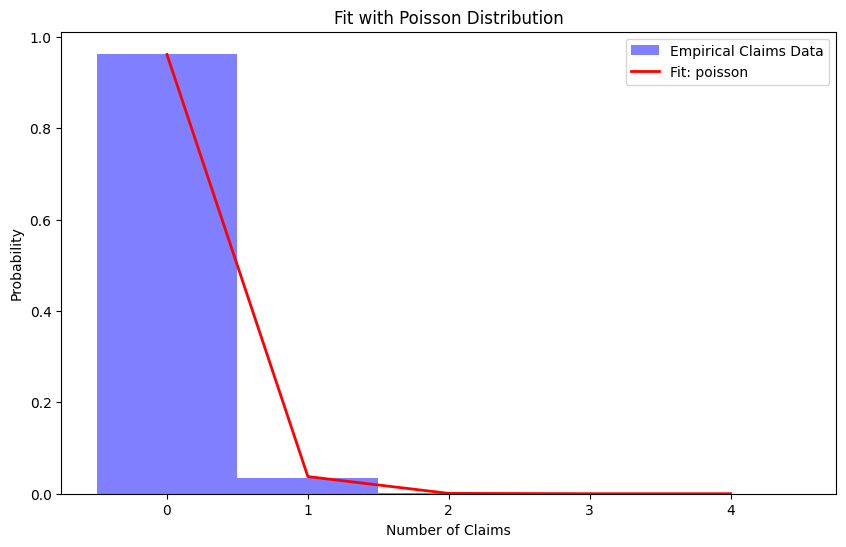

AIC for Fit with Poisson Distribution: 33460.499374859624
BIC for Fit with Poisson Distribution: 33470.0122603238


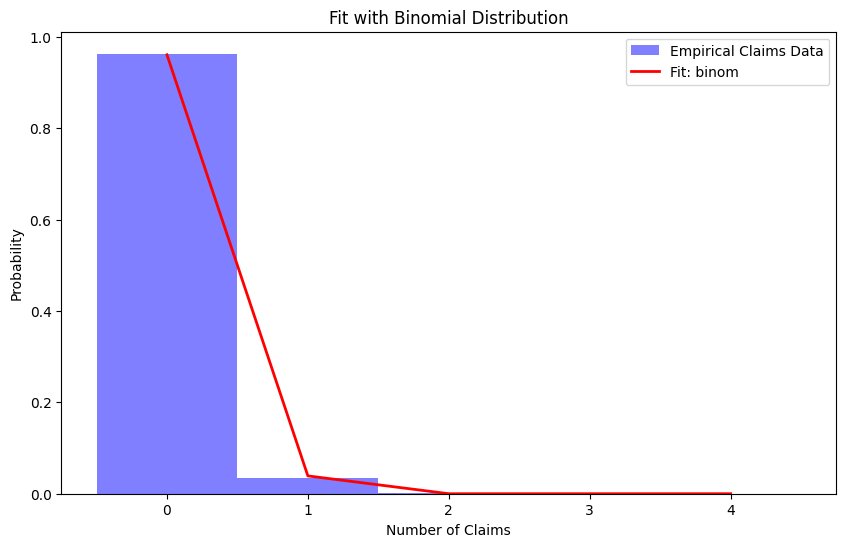

AIC for Fit with Binomial Distribution: 40311.18360245922
BIC for Fit with Binomial Distribution: 40330.20933338556


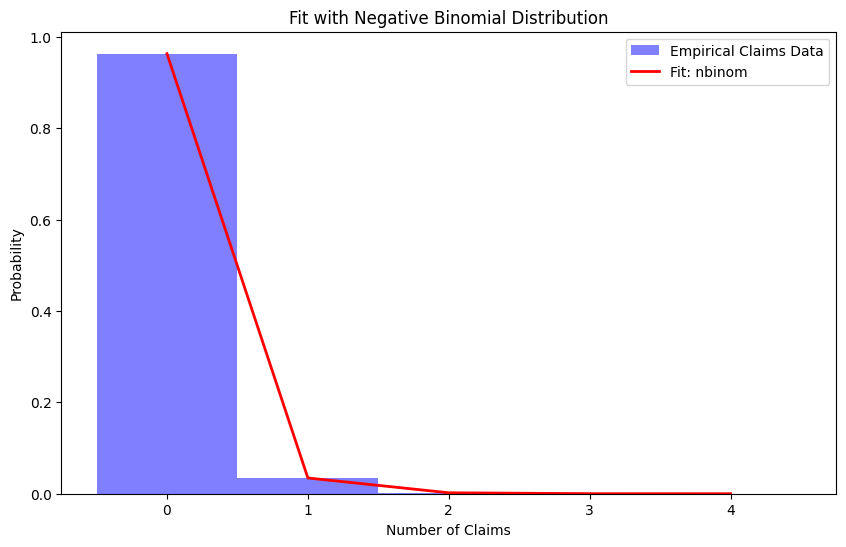

AIC for Fit with Negative Binomial Distribution: 33220.908366396994
BIC for Fit with Negative Binomial Distribution: 33239.934097323334


In [31]:
# Poisson Distribution Fitting
lambda_poisson = np.mean(claim_counts)
params_poisson = [lambda_poisson]
plot_fit(claim_counts, poisson, params_poisson, 'Fit with Poisson Distribution', dist_type='discrete')

# Binomial Distribution Fitting
n_trials = 1  # This should be adjusted based on your specific scenario
p_success = np.mean(claim_counts) / n_trials
params_binom = [n_trials, p_success]
plot_fit(claim_counts, binom, params_binom, 'Fit with Binomial Distribution', dist_type='discrete')

# Negative Binomial Distribution Fitting
r_negbin = (np.mean(claim_counts)**2) / (np.var(claim_counts) - np.mean(claim_counts))
p_negbin = r_negbin / (r_negbin + np.mean(claim_counts))
params_negbin = [r_negbin, p_negbin]
plot_fit(claim_counts, nbinom, params_negbin, 'Fit with Negative Binomial Distribution', dist_type='discrete')

In [32]:
def calculate_aic(n, ll, k):
    """
    Calculate Akaike Information Criterion.
    """
    return 2*k - 2*ll + 2*k*(k+1)/(n-k-1)

def calculate_bic(n, ll, k):
    """
    Calculate Bayesian Information Criterion.
    """
    return -2*ll + k*np.log(n)

def plot_fit_severity(x, dist, params, title):
    plt.figure(figsize=(10, 6))
    count, bins, ignored = plt.hist(x, bins=30, density=True, alpha=0.5, color='g', label='Empirical Severity Data')
    xmin, xmax = plt.xlim()
    x_range = np.linspace(xmin, xmax, 100)

    if dist != pareto:
        probabilities = dist.pdf(x_range, *params)
        log_likelihood = np.sum(np.log(dist.pdf(x, *params)))
    else:
        probabilities = dist.pdf(x_range, *params)
        log_likelihood = np.sum(np.log(dist.pdf(x, *params)))

    plt.plot(x_range, probabilities, 'k-', linewidth=2, label=f'Fit: {dist.name}')
    plt.title(title)
    plt.xlabel('Claim Amount')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

    # Calculate AIC and BIC
    n = len(x)
    k = len(params)
    aic = calculate_aic(n, log_likelihood, k)
    bic = calculate_bic(n, log_likelihood, k)
    print(f"AIC for {title}: {aic}")
    print(f"BIC for {title}: {bic}")

# Fitting Claim Severity Distributions

## Fitting with Log-normal Distribution, Pareto and Gamma
We fit the claim severity data to a log-normal, Pareto and Gamma distribution. The parameters of the distribution are estimated using the `lognorm.fit` method with `floc` set to 0. 
The fitted parameters are then used to plot the severity distribution

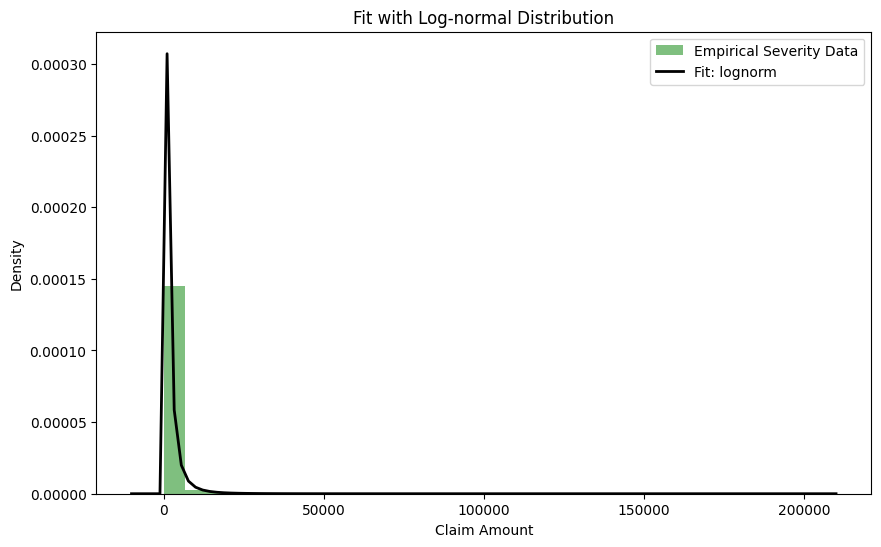

AIC for Fit with Log-normal Distribution: 61901.186253035194
BIC for Fit with Log-normal Distribution: 61919.79944829225


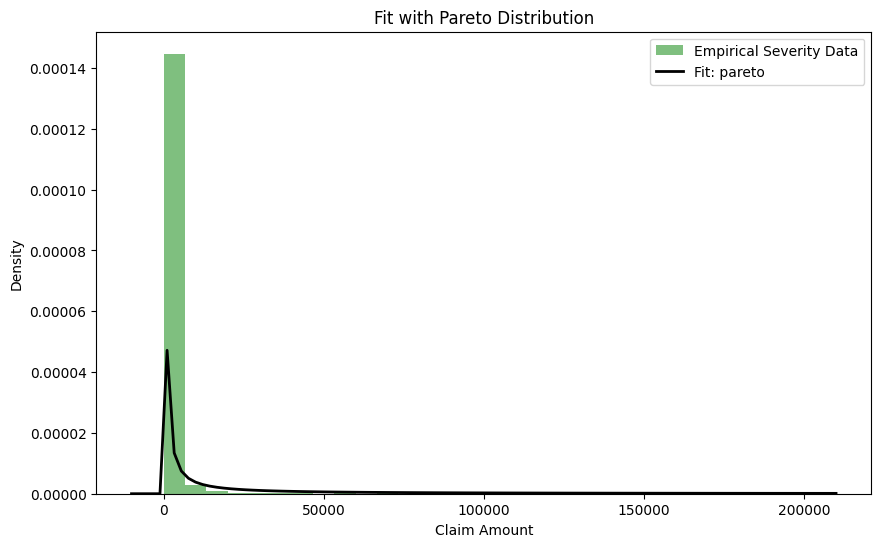

AIC for Fit with Pareto Distribution: 71878.08174119866
BIC for Fit with Pareto Distribution: 71896.69493645572


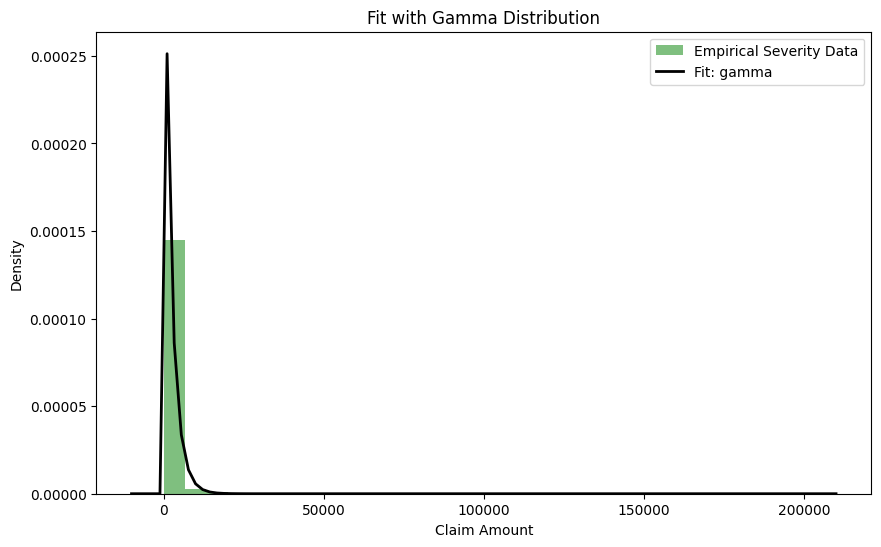

AIC for Fit with Gamma Distribution: 63202.40850800119
BIC for Fit with Gamma Distribution: 63221.021703258244


In [33]:
# Log-normal fitting
shape, loc, scale = lognorm.fit(non_zero_claims, floc=0)
params_lognorm = [shape, loc, scale]
plot_fit_severity(non_zero_claims, lognorm, params_lognorm, 'Fit with Log-normal Distribution')

# Pareto fitting
b, loc, scale = pareto.fit(non_zero_claims, floc=0)  # Fitting with floc set to 0
params_pareto = [b, loc, scale]
plot_fit_severity(non_zero_claims, pareto, params_pareto, 'Fit with Pareto Distribution')

# Gamma fitting
alpha, loc, beta = gamma.fit(non_zero_claims, floc=0)  # Adjusting fit parameters as needed
params_gamma = [alpha, loc, beta]
plot_fit_severity(non_zero_claims, gamma, params_gamma, 'Fit with Gamma Distribution')

# Choosing the Best Distribution for Claim Frequency and Severity

## Claim Frequency Distribution

To determine the best distribution for claim frequency, we compared the AIC and BIC values for Poisson, Binomial, and Negative Binomial distributions. The distribution with the lowest AIC and BIC values is considered the best fit.

### AIC and BIC Values for Claim Frequency Distributions:
- **Poisson Distribution**:
  - AIC: 33460.499374859624
  - BIC: 33470.0122603238
- **Negative Binomial Distribution**:
  - AIC: 33220.908366396994
  - BIC: 33239.934097323334
- **Binomial Distribution**:
  - AIC: 40311.18360245922
  - BIC: 40330.20933338556

### Conclusion:
The Negative Binomial distribution has the lowest AIC and BIC values, indicating that it is the best fit for the claim frequency data.

## Claim Severity Distribution

To determine the best distribution for claim severity, we compared the AIC and BIC values for Log-normal, Pareto, and Gamma distributions. The distribution with the lowest AIC and BIC values is considered the best fit.

### AIC and BIC Values for Claim Severity Distributions:
- **Log-normal Distribution**:
  - AIC: 61901.186253035194
  - BIC: 61919.79944829225
- **Pareto Distribution**:
  - AIC: 71878.08174119866
  - BIC: 71896.69493645572
- **Gamma Distribution**:
  - AIC: 63202.40850800119
  - BIC: 63221.021703258244

### Conclusion:
The Log-normal distribution has the lowest AIC and BIC values, indicating that it is the best fit for the claim severity data.

# Predicting Total Losses using Monte Carlo Simulation

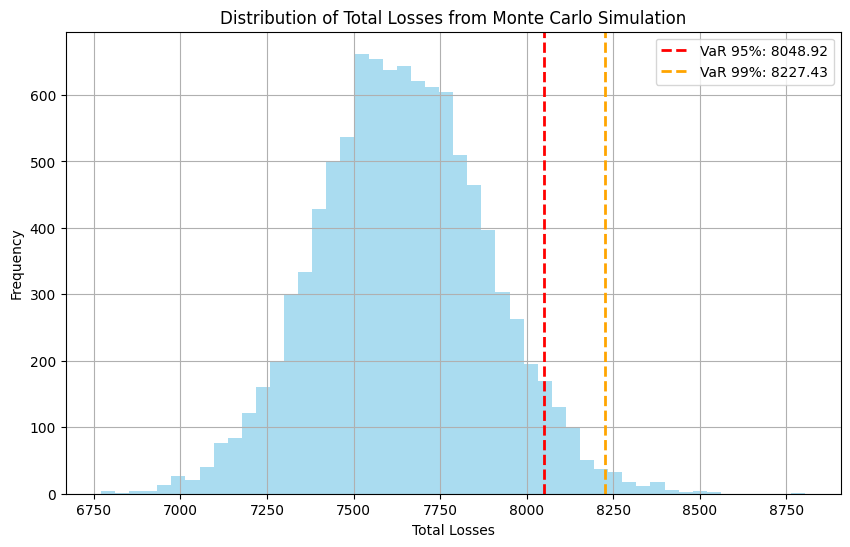

Expected Total Loss: 7641.68
95th Percentile Total Loss (VaR 95%): 8048.92
99th Percentile Total Loss (VaR 99%): 8227.43


In [34]:
# Claim_counts holds historical claim frequency data
# Non_zero_claims holds historical non-zero claim severities

# Use the fitted parameters from the Negative Binomial and Log-normal fits
# For claim frequency (Negative Binomial)
params_negbin = [r_negbin, p_negbin]  # Fitted Negative Binomial params
# For claim severity (Log-normal)
params_lognorm = [shape, loc, scale]  # Fitted Log-normal params

# Number of simulations and policies
n_simulations = 10000
n_policies = len(claims_data)

# Pre-allocate an array for total losses
total_losses = np.zeros(n_simulations)

# Monte Carlo simulation loop
for i in range(n_simulations):
    # Simulate number of claims for all policies at once
    num_claims = nbinom.rvs(r_negbin, p_negbin, size=n_policies)
    
    # Initialize total claim severity for each policy
    total_claim_severity = np.zeros(n_policies)
    
    # For policies with claims, simulate the severity
    for j in range(n_policies):
        if num_claims[j] > 0:
            # Simulate claim severity for each claim and sum them for the policy
            total_claim_severity[j] = lognorm.rvs(shape, loc, scale, size=num_claims[j]).sum()
    
    # Store the total loss for this simulation
    total_losses[i] = total_claim_severity.sum()

# Calculate expected total loss from the simulation results 
expected_total_loss = np.mean(total_losses)

# Calculate Value-at-Risk (VaR) at different confidence levels (95% and 99%)
var_95 = np.percentile(total_losses, 95)
var_99 = np.percentile(total_losses, 99)

# Plot the total losses distribution and highlight VaR levels
plt.figure(figsize=(10, 6))
plt.hist(total_losses, bins=50, color='skyblue', alpha=0.7)
plt.axvline(var_95, color='red', linestyle='dashed', linewidth=2, label=f'VaR 95%: {var_95:.2f}')
plt.axvline(var_99, color='orange', linestyle='dashed', linewidth=2, label=f'VaR 99%: {var_99:.2f}')
plt.title('Distribution of Total Losses from Monte Carlo Simulation')
plt.xlabel('Total Losses')
plt.ylabel('Frequency')
plt.grid(True)
plt.legend()
plt.show()

# Printing Risk Measures 
print(f"Expected Total Loss: {expected_total_loss:.2f}")
print(f"95th Percentile Total Loss (VaR 95%): {var_95:.2f}")
print(f"99th Percentile Total Loss (VaR 99%): {var_99:.2f}")

# Resulting Distribution from Convolution

In this Monte Carlo simulation, we model the claim frequency using a Negative Binomial distribution and the claim severity using a Log-normal distribution. The resulting distribution of total losses from this convolution is an aggregated loss distribution.

## Characteristics of the Simulated Distribution:
- **Claim Frequency**: Modeled using a Negative Binomial distribution.
- **Claim Severity**: Modeled using a Log-normal distribution.
- **Total Losses**: The sum of individual claim severities for each simulated number of claims.

### Analysis of Simulated Total Losses:
- **Expected Total Loss**: The mean of the total losses from the simulations.
- **Value-at-Risk (VaR)**: Calculated at different confidence levels (e.g., 95% and 99%) to assess the risk of extreme losses.

# Logistic Regression: Predict the probability of filing a claim (i.e., whether a claim is made or not)

## Goal: Understand which characteristics increase or decrease the likelihood of a policyholder filing a claim (frequency)

In [141]:
# Create binary variable for claims (1 if there was at least one claim, 0 otherwise)
claims_data['Claim_binary_variable'] = claims_data['ClaimNb'].apply(lambda x: 1 if x > 0 else 0)

# Convert categorical variables to dummy variables (e.g., Area, VehBrand, VehGas, Region)
claims_data = pd.get_dummies(claims_data, columns=['Area', 'VehBrand', 'VehGas', 'Region'], drop_first=True, dtype = int)

# Select the independent variables (Excluding IDpol and ClaimAmount)
independent_vars = ['Exposure', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density']

# Adding dummy variables to independent_vars for policyholder's area, vehicle's brand, the type of gas used and for the region of the policyholder
independent_vars += [col for col in claims_data.columns if col.startswith('Area_') or col.startswith('VehBrand_') or col.startswith('VehGas_') or col.startswith('Region_')]

# Add interaction terms to the model (e.g., DrivAge * VehPower, Exposure * BonusMalus) to capture non-linear relationships between variables 
claims_data['DrivAge_VehPower'] = claims_data['DrivAge'] * claims_data['VehPower']
claims_data['Exposure_BonusMalus'] = claims_data['Exposure'] * claims_data['BonusMalus']
independent_vars += ['DrivAge_VehPower', 'Exposure_BonusMalus']

# Add constant term to the model
X = sm.add_constant(claims_data[independent_vars])

# Define the dependent variable
y = claims_data['Claim_binary_variable']

# Fit the logistic regression model
logit_model = sm.Logit(y, X).fit()

print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.147717
         Iterations 8
                             Logit Regression Results                            
Dep. Variable:     Claim_binary_variable   No. Observations:               100000
Model:                             Logit   Df Residuals:                    99954
Method:                              MLE   Df Model:                           45
Date:                   Wed, 09 Oct 2024   Pseudo R-squ.:                 0.06001
Time:                           18:48:45   Log-Likelihood:                -14772.
converged:                          True   LL-Null:                       -15715.
Covariance Type:               nonrobust   LLR p-value:                     0.000
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -5.8801      0.257    -22.847      0.000   

### Summary of Logistic Regression Model Interpretation
Here is a summary of the key findings:

#### Significant Variables

1. **VehPower**
   - **Impact**: Positive
   - **Interpretation**: Higher vehicle power increases the likelihood of an insurance claim.

2. **VehAge**
   - **Impact**: Negative
   - **Interpretation**: Older vehicles are less likely to have insurance claims.

3. **DrivAge**
   - **Impact**: Positive
   - **Interpretation**: Older drivers are more likely to file insurance claims.

4. **BonusMalus**
   - **Impact**: Positive
   - **Interpretation**: A higher Bonus-Malus coefficient increases the likelihood of an insurance claim.

5. **Area (C, D, E, F)**
   - **Impact**: Positive
   - **Interpretation**: Certain geographical areas (C, D, E, F) have a higher likelihood of insurance claims.

6. **VehBrand (B11, B13)**
   - **Impact**: Positive
   - **Interpretation**: Certain vehicle brands (B11, B13) are associated with a higher likelihood of insurance claims.

7. **VehBrand (B12)**
   - **Impact**: Negative
   - **Interpretation**: The vehicle brand B12 is associated with a lower likelihood of insurance claims.

8. **VehGas (Regular)**
   - **Impact**: Negative
   - **Interpretation**: Vehicles using regular gas are less likely to have insurance claims.

9. **Region (R73, R82)**
   - **Impact**: Mixed
   - **Interpretation**: Certain regions (R73, R82) have significant impacts on the likelihood of insurance claims.

10. **Interaction Terms**
    - **DrivAge_VehPower**: Not significant
    - **Exposure_BonusMalus**: Positive and significant
    - **Interpretation**: The interaction between Exposure and Bonus-Malus significantly increases the likelihood of an insurance claim.

#### Non-Significant Variables

1. **Exposure**
2. **Density**
3. **Several Areas, Vehicle Brands, and Regions**

These variables do not have a statistically significant impact on the likelihood of an insurance claim.

### Conclusion

The model identifies several key factors that significantly influence the probability of an insurance claim. These insights can be used to develop a better Risk Group Assignment Algorithm and adjust insurance premiums. Variables such as vehicle power, age of the vehicle, age of the driver, and certain geographical areas and vehicle brands play a crucial role in predicting insurance claims in our dataset.

In [99]:
# verifying for multicollinearity using VIF (Variance Inflation Factor)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
vif_data

,feature,VIF
0,const,92.060682
1,Exposure,1.157528
2,VehPower,1.138282
3,VehAge,1.333830
4,DrivAge,1.357099
5,BonusMalus,1.361652
6,Density,8.593092
7,Area_B,1.589420
8,Area_C,2.261091
9,Area_D,2.312183


In [43]:
# Check for correlation between risk caracteristics
claims_data[['VehPower', 'DrivAge', 'BonusMalus', 'Density', 'Exposure']].corr()

,VehPower,DrivAge,BonusMalus,Density,Exposure
VehPower,1.000000,0.028375,-0.077144,0.044586,-0.043155
DrivAge,0.028375,1.000000,-0.480037,-0.005337,0.176111
BonusMalus,-0.077144,-0.480037,1.000000,0.080366,-0.182107
Density,0.044586,-0.005337,0.080366,1.000000,-0.070458
Exposure,-0.043155,0.176111,-0.182107,-0.070458,1.000000


# Risk Group Assignment Algorithm based on  individual characteristics

## Principles for Risk Categorization (Based on the lecture : Topic 2B: Underwriting): 

Actuarial Criteria:

- **Accuracy**: Variables must have a clear link to expected costs and losses, which our regression analysis helps confirm.
- **Homogeneity**: Each risk group should have similar expected claim costs.
- **Credibility**: Risk categories should be large enough to be statistically reliable.
- **Predictive Stability**: Differences between categories should remain stable over time.

Ce code calcule des seuils pour classifier les risques en fonction de la fréquence et de la sévérité des réclamations avec des quantiles, et applique cette classification à chaque titulaire de police.

In [236]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Define the features and target variables
X = claims_data[['VehAge', 'DrivAge', 'BonusMalus', 'VehPower', 'Area', 'VehGas']]  # Observable characteristics
y = claims_data['ClaimNb']  # Assuming you are using ClaimNb to derive the risk class

# Define categorical and numerical features
categorical_features = ['Area', 'VehGas']
numerical_features = ['VehAge', 'DrivAge', 'BonusMalus', 'VehPower']

# Create a preprocessing pipeline to scale numerical features and encode categorical ones
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)])

# Apply preprocessing
X_preprocessed = preprocessor.fit_transform(X)

# Function to classify risk group based on observable characteristics
def classify_risk_group(row):
    if row['DrivAge'] > 50 and row['VehAge'] < 5:
        return 'Preferred'
    elif row['DrivAge'] <= 50 and row['VehAge'] >= 5:
        return 'Standard'
    else:
        return 'Substandard Risk'

# Apply the function to classify each policyholder into a risk group
claims_data['RiskGroup'] = claims_data.apply(classify_risk_group, axis=1)

In [240]:
# Example of new applicant data (to be classified)
new_applicants = pd.DataFrame({
    'VehAge': np.random.randint(0, 30, size=10),   # Vehicle Age
    'DrivAge': np.random.randint(18, 80, size=10),  # Driver Age
    'BonusMalus': np.random.randint(50, 300, size=10),  # Bonus/Malus score
    'VehPower': np.random.randint(4, 20, size=10),  # Vehicle Power
    'Area': np.random.choice(['A', 'B', 'C', 'D', 'E', 'F'], size=10),    # Area code
    'VehGas': np.random.choice(['Diesel', 'Regular'], size=10)  # Vehicle fuel type
})

# Preprocess the new applicant data
new_applicants_preprocessed = preprocessor.transform(new_applicants)

# Classify the new applicant based on the predefined thresholds
new_applicants['RiskGroup'] = new_applicants.apply(classify_risk_group, axis=1)

# Display the classification result for the new applicant
new_applicants[['VehAge', 'DrivAge', 'BonusMalus', 'RiskGroup']]

,VehAge,DrivAge,BonusMalus,RiskGroup
0,3,48,176,Substandard Risk
1,3,49,211,Substandard Risk
2,20,46,116,Standard
3,1,51,182,Preferred
4,13,71,247,Substandard Risk
5,14,53,166,Substandard Risk
6,21,42,273,Standard
7,25,62,265,Substandard Risk
8,28,45,221,Standard
9,1,45,185,Substandard Risk


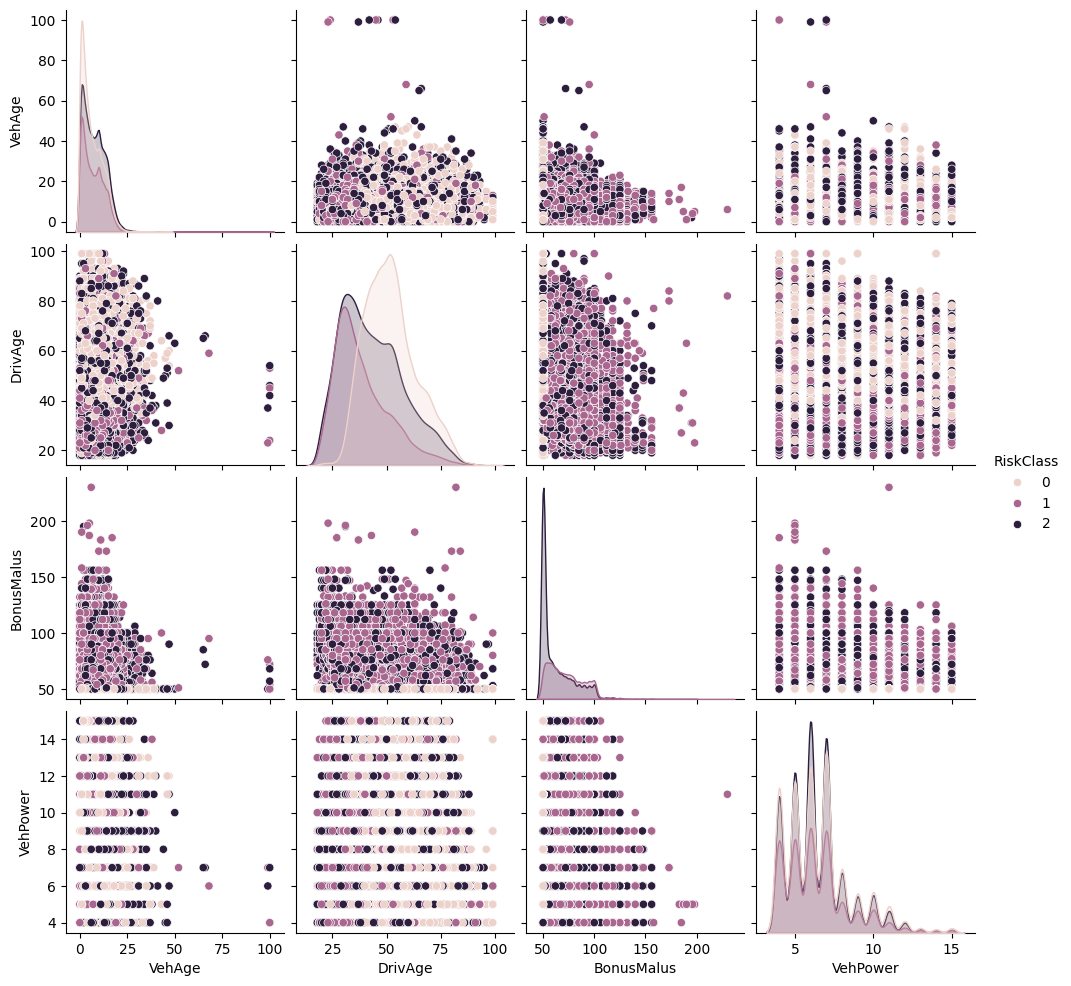

,VehAge,DrivAge,BonusMalus,VehPower,Area,VehGas,RiskClass
0,17,53,64,5,E,Diesel,1
1,2,27,64,5,E,Diesel,1
2,11,67,50,7,E,Regular,0
3,8,28,60,5,B,Diesel,2
4,1,38,50,11,A,Regular,2
...,...,...,...,...,...,...,...
99995,11,37,56,5,C,Diesel,2
99996,13,58,50,6,E,Diesel,0
99997,1,49,50,5,E,Diesel,0
99998,9,36,54,9,D,Regular,1


In [113]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import seaborn as sns

# Définition des variables de caractéristiques et de la cible:
X = claims_data[['VehAge', 'DrivAge', 'BonusMalus', 'VehPower', 'Area', 'VehGas']] # X contient les caractéristiques observables des données d'assurance.
y = claims_data['ClaimNb'] # y est la variable cible, ici le nombre de réclamations (ClaimNb)

# Définition des caractéristiques catégorielles et numériques:
categorical_features = ['Area', 'VehGas']
numerical_features = ['VehAge', 'DrivAge', 'BonusMalus', 'VehPower']

# Création d'un pipeline de prétraitement: 
# ColumnTransformer applique StandardScaler aux caractéristiques numériques et OneHotEncoder aux caractéristiques catégorielles:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features)])

# Les transformations sont appliquées aux données d'entrée X pour obtenir X prétraité:
X_preprocessed = preprocessor.fit_transform(X)

# Applique un modèle de mélange gaussien avec 3 composantes, pour identifier les classes de risque latentes: 
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(X_preprocessed)

# Les classes de risque latentes sont prédites et ajoutées aux données d'origine sous la colonne 'RiskClass':
claims_data['RiskClass'] = gmm.predict(X_preprocessed)

# Visualisation des classes de risque prédites:
sns.pairplot(claims_data, hue='RiskClass', vars=['VehAge', 'DrivAge', 'BonusMalus', 'VehPower'])
plt.show()

claims_data[['VehAge', 'DrivAge', 'BonusMalus', 'VehPower', 'Area', 'VehGas', 'RiskClass']]

In [126]:
# Ajouter les prédictions de cluster aux données d'origine
claims_data['RiskClass'] = gmm.predict(X_preprocessed)

# Sélectionner uniquement les colonnes numériques
numeric_columns = claims_data.select_dtypes(include=[np.number]).columns

# Calculer les statistiques descriptives pour chaque cluster en utilisant uniquement les colonnes numériques
cluster_summary = claims_data.groupby('RiskClass')[numeric_columns].describe()

cluster_summary

IDpol                                                          \
             count          mean           std   min        25%        50%   
RiskClass                                                                    
0          38680.0  2.680569e+06  1.659145e+06  15.0  1171639.0  2280714.5   
1          24020.0  2.706268e+06  1.653954e+06  30.0  1190536.5  2276423.0   
2          37300.0  2.495565e+06  1.612593e+06  42.0  1122931.5  2228020.5   

                                  ClaimNb            ... ClaimAmount  \
                  75%        max    count      mean  ...         75%   
RiskClass                                            ...               
0          4074798.75  6114324.0  38680.0  0.032653  ...         0.0   
1          4048601.75  6114321.0  24020.0  0.051998  ...         0.0   
2          4014976.25  6114291.0  37300.0  0.037265  ...         0.0   

                    RiskClass                                     
                max     count mean  std  min  25%  50%  75%  max  
RiskClass                                                         
0          200000.0   38680.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
1          200000.0   24020.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  
2           91054.1   37300.0  2.0  0.0  2.0  2.0  2.0  2.0  2.0  

[3 rows x 80 columns]

In [127]:
# Extraire les statistiques descriptives pour les montants des réclamations
claim_amount_stats = cluster_summary['ClaimAmount'][['mean', 'std', 'max']]

# Afficher les statistiques pour chaque classe de risque
print(claim_amount_stats)

# Identifier la classe de risque la plus risquée
most_risky_class = claim_amount_stats['mean'].idxmax()
print(f"La classe de risque la plus risquée est : {most_risky_class}")

                 mean          std       max
RiskClass                                   
0           77.991224  1895.589358  200000.0
1          106.692965  1797.844786  200000.0
2           55.778099   694.577535   91054.1
La classe de risque la plus risquée est : 1
